In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import pandas as pd
import re
from typing import Dict, Tuple

In [5]:
# Config: Weights & Categories:

LAMBDA = 0.5
ALPHA, BETA, GAMMA = 0.4, 0.2, 0.4 # PDS component weights

#Pragmatic categories for loss/hallucination
CATS = ["hedges", "modals", "disfluencies", "conditionals"]

In [6]:
# ---------- REGEX --------
LEX = {
    # --- HEDGES (stance-softeners) ---
    # Core epistemic verbs/adverbs + approximators + shields + common metacognitive forms
    "hedges_uncertain":  r"\b(think|believe|suppose|assume|suggest|seem|appear|tend|guess|reckon|figure|imagine|suspect)\b|"
                         r"\b(maybe|perhaps|possibly|probably|arguably|apparently|seemingly)\b|"
                         r"\b(sort of|kind of|sorta|kinda|like|somewhat|quite|rather|fairly|pretty)\b'|"
                         r"\b(according to|as far as|to my knowledge|if I recall|if I remember correctly)\b|"
                         r"\b(just|only|merely|simply|basically|actually)\b"
                         r"\bto\s+the\s+best\s+of\s+my\s+(?:knowledge|recollection|memory)\b"
                         r"\bif\s+i(?:'m| am)\s+not\s+mistaken\b|"
                         r"\b(approximately|roughly|about|around|or so|give or take|more or less|ish)\b"
                         r"\b(?:i|i'm|im)\s+not\s+(?:sure|certain|positive)\b|"
                         r"\b(it (?:seemed|looked|appeared|sounded) (?:like|as (?:if|though))|from what I could (?:see|tell|hear))\b"
                         r"\b(?:i\s+)?(?:don'?t|can'?t)\s+(?:know|remember|recall)(?:\s+(?:exactly|for\s+sure))?\b",

    # --- MODALS (verbs only; keep adverbs like 'definitely' out to avoid double-counting with certainty) ---
    "modals":            r"\b(may|might|could|should|would|can|must)\b|"
                         r"\b(might|could|would|should|must)\s+have\b|"
                         r"\b(can|could|be\s+able\s+to)\b|"
                         r"\b(can'?t|couldn'?t|wouldn'?t|shouldn'?t|mustn'?t|won'?t|may\s+not|might\s+not)\b",

    # --- DISFLUENCIES (keep the classics + common discourse fillers) ---
    "disfluencies":      r"\b(um+|uh+|er+|ah+|hmm+)\b|"
                         r"\b(you\s+know|like)\b|"
                         r"\b(i\s+mean)\b|"
                         r"(?:\.\.\.|—|–)\s*$",   # trailing off (ellipsis or em/en dash at end of line)

    # --- CONDITIONALS (compact but covers legal counterfactuals & alternatives) ---
    "conditionals":      r"\bif\b[^.?!]*|"
                         r"\bunless\b|"
                         r"\bprovided\s+that|assuming|in\s+case\b|"
                         r"\bwhether\b|"
                         r"\botherwise|or\s+else|alternatively\b|"
                         r"\bbut[-\s]?for\b|"
                         r"\b(would|could|might|should)\s+have\b"
                         r"b(?:suppose|supposing|assuming|say) (?:that|we|you|I|he|she|they)\b",

    # ---------- CII-only buckets ----------
    # Low/uncertain cues (subset of hedges; used for CII denominator)
    "cii_uncertain":     r"\b(i\s+think|i\s+believe|i\s+suppose|i\s+guess|reckon|imagine|suspect|seem|appears?)\b|"
                         r"\bmaybe|perhaps|possibly|probably\b|"
                         r"\b(?:i|i'm|im)\s+not\s+(?:sure|certain|positive)\b|"
                         r"\b(?:i\s+)?(?:don'?t|can'?t)\s+(?:know|remember|recall)\b",

    # High/categorical certainty (CII numerator via added certainty)
    "cii_certain_high":  r"\b(definitely|certainly|clearly|absolutely|undoubtedly|without\s+(?:any\s+)?doubt|for\s+sure)\b"
}




In [7]:
# compile regex once (case-insensitive)
R = {k: re.compile(v, flags=re.IGNORECASE) for k, v in LEX.items()}

def count_matches(pattern: re.Pattern, text: str) -> int:
    if not text: return 0
    return len(pattern.findall(text))

def feature_counts(text: str) -> dict:
    return {
        "hedges":        count_matches(R["hedges_uncertain"], text),
        "modals":        count_matches(R["modals"], text),
        "disfluencies":  count_matches(R["disfluencies"], text),
        "conditionals":  count_matches(R["conditionals"], text),

        # For CII:
        "uncertain":     count_matches(R["hedges_uncertain"], text),   # denominator
        "certain_high":  count_matches(R["cii_certain_high"], text),    # <-- rename here
    }


In [17]:
# -----------------------------
# 3) Core metrics
# -----------------------------
def certainty_inflation_index(src, summ, w_add=0.5):
    # w_add in [0,1] weights added-certainty vs suppressed-uncertainty
    src_unc = max(src["uncertain"], 0)
    denom = max(src_unc, 1)

    C_add = max(0, summ["certain_high"] - src["certain_high"]) / denom
    C_sup = max(0, src["uncertain"] - summ["uncertain"]) / denom

    C = w_add * C_add + (1 - w_add) * C_sup
    return max(0.0, min(1.0, C))

def loss_rate(src: Dict[str, int], summ: Dict[str, int]) -> float:
    """
    Proportion of source pragmatic features (across CATS) that do NOT appear in the summary.
    We operate on counts (bag-of-cues approximation).
    """
    src_total  = sum(src[c] for c in CATS)
    if src_total == 0:
        return 0.0
    preserved = sum(min(src[c], summ[c]) for c in CATS)
    lost = max(0, src_total - preserved)
    return lost / src_total

def hallucination_rate(src: Dict[str, int], summ: Dict[str, int]) -> float:
    """
    Proportion of summary pragmatic features that were not in the source.
    """
    summ_total = sum(summ[c] for c in CATS)
    if summ_total == 0:
        return 0.0
    hallucinated = sum(max(0, summ[c] - src[c]) for c in CATS)
    return hallucinated / summ_total

def pds(src: Dict[str, int], summ: Dict[str, int]) -> float:
    """
    Pragmatic Distortion Score: weighted combination of Loss, Hallucination, Certainty Inflation.
    """
    L = loss_rate(src, summ)
    H = hallucination_rate(src, summ)
    C = certainty_inflation_index(src, summ)
    score = ALPHA * L + BETA * H + GAMMA * C
    return max(0.0, min(1.0, score))

def pdci(src: Dict[str, int], summ: Dict[str, int], lambda_: float = LAMBDA) -> Tuple[float, float, float]:
    """
    Return (PDCI, CII, PDS).
    PDCI = lambda * CII + (1 - lambda) * PDS.
    """
    C = certainty_inflation_index(src, summ)
    P = pds(src, summ)
    combined = lambda_ * C + (1 - lambda_) * P
    return round(combined, 4), round(C, 4), round(P, 4)

In [18]:
# -----------------------------
# 4) Row-wise application helpers
# -----------------------------
def analyze_pair(source_text: str, summary_text: str) -> Dict[str, float]:
    src = feature_counts(source_text or "")
    summ = feature_counts(summary_text or "")
    combined, C, P = pdci(src, summ, LAMBDA)
    out = {
        "src_uncertain": src["uncertain"],
        "src_certain_high": src["certain_high"],
        "sum_uncertain": summ["uncertain"],
        "sum_certain_high": summ["certain_high"],
        "loss_rate": round(loss_rate(src, summ), 4),
        "hallucination_rate": round(hallucination_rate(src, summ), 4),
        "CII": C,
        "PDS": P,
        "PDCI": combined,
    }
    # Also include per-category preservation (optional, helpful for plots)
    for c in CATS:
        denom = max(src[c], 1)
        out[f"preserve_{c}"] = round(min(summ[c] / denom, 1.0), 4)
    return out


In [19]:
# -----------------------------
# 5) Example on a small list (you can delete this)
# -----------------------------
examples = [
    {
        "id": "ex1",
        "model": "BART",
        "condition": "default",
        "source_text":  "I think it might have been Tuesday, I'm not sure, um, around 9.",
        "summary_text": "The witness stated it was Tuesday at around 9.",
    },
    {
        "id": "ex2",
        "model": "Pegasus",
        "condition": "default",
        "source_text":  "Maybe Wednesday or Thursday, I believe. Uh, not totally sure.",
        "summary_text": "It was definitely Wednesday.",
    },
]

df = pd.DataFrame(examples)
metrics = df.apply(lambda r: pd.Series(analyze_pair(r["source_text"], r["summary_text"])), axis=1)
result = pd.concat([df, metrics], axis=1)
result

,id,model,condition,source_text,summary_text,src_uncertain,src_certain_high,sum_uncertain,sum_certain_high,loss_rate,hallucination_rate,CII,PDS,PDCI,preserve_hedges,preserve_modals,preserve_disfluencies,preserve_conditionals
0,ex1,BART,default,"I think it might have been Tuesday, I'm not su...",The witness stated it was Tuesday at around 9.,1.0,0.0,0.0,0.0,1.0,0.0,0.50,0.6,0.550,0.0,0.0,0.0,0.0
1,ex2,Pegasus,default,"Maybe Wednesday or Thursday, I believe. Uh, no...",It was definitely Wednesday.,2.0,0.0,0.0,1.0,1.0,0.0,0.75,0.7,0.725,0.0,0.0,0.0,0.0


------

-----

## Model Tests

### Pegasus

In [20]:
df_pegasus = pd.read_csv("/content/drive/MyDrive/Dissertation/pegasus/curated_pegasus_results.csv")
df_pegasus.head()

,ID,Excerpt,Feature,SubFeature,GoldSummary,pegasus_summary
0,1.0,I might have seen him in the lobby,Hedge,Modal verb,The deponent says they might have seen him in ...,"I'm not sure what happened to him, but I'm pre..."
1,2.0,I probably saw the car at the intersection,Hedge,Adverbial hedge,The deponent states they probably saw the car ...,This is the moment a car crashed into the back...
2,3.0,I don't know if the door was locked,Hedge,Phrase hedge,The deponent says they don't know if the door ...,BBC Sport takes a look back at some of the key...
3,4.0,It seems the file was misplaced,Hedge,Lexical hedge,The deponent indicates it seems the file was m...,Check out the video above to see what happened...
4,5.0,I think he was present that day,Hedge,Phrase hedge,The deponent thinks he was present that day,BBC News NI looks back at some of the most mem...


In [21]:
df_pegasus["Excerpt"] = df_pegasus["Excerpt"].fillna("").astype(str)
df_pegasus["pegasus_summary"] = df_pegasus["pegasus_summary"].fillna("").astype(str)

results = df_pegasus.apply(
    lambda r: pd.Series(analyze_pair(r["Excerpt"], r["pegasus_summary"])), axis=1
)

In [22]:
#PDCI Analyzer
results = df_pegasus.apply(lambda r: pd.Series(analyze_pair(r["Excerpt"], r["pegasus_summary"])), axis=1)
df_pegasus_out = pd.concat([df_pegasus, results], axis=1)

In [23]:
table = df_pegasus_out[["CII","PDS","PDCI"]].mean().round(3)
print("Pegasus Average Scores")
print(table)

Pegasus Average Scores
CII     0.129
PDS     0.321
PDCI    0.225
dtype: float64


In [24]:
df_pegasus_out[["src_uncertain","sum_uncertain","src_certain_high","sum_certain_high"]].mean()


,0
src_uncertain,0.424242
sum_uncertain,0.083333
src_certain_high,0.030303
sum_certain_high,0.000000


In [26]:
df_pegasus_out.sort_values("loss_rate", ascending=False).head(5)[["Excerpt","pegasus_summary","src_uncertain","sum_uncertain"]]


,Excerpt,pegasus_summary,src_uncertain,sum_uncertain
0,I might have seen him in the lobby,"I'm not sure what happened to him, but I'm pre...",0.0,0.0
1,I probably saw the car at the intersection,This is the moment a car crashed into the back...,1.0,0.0
2,I don't know if the door was locked,BBC Sport takes a look back at some of the key...,0.0,0.0
4,I think he was present that day,BBC News NI looks back at some of the most mem...,1.0,0.0
125,"I think I saw him leave around two o'clock, bu...",I've been having a bit of a problem rememberin...,2.0,0.0


------

### BART

In [30]:
df_bart = pd.read_csv("/content/drive/MyDrive/Dissertation/bart/curated_bart.csv")
df_bart.head()

,ID,Excerpt,Feature,SubFeature,GoldSummary,bart_summary
0,1.0,I might have seen him in the lobby,Hedge,Modal verb,The deponent says they might have seen him in ...,I might have seen him in the lobby. I might ha...
1,2.0,I probably saw the car at the intersection,Hedge,Adverbial hedge,The deponent states they probably saw the car ...,I probably saw the car at the intersection. I ...
2,3.0,I don't know if the door was locked,Hedge,Phrase hedge,The deponent says they don't know if the door ...,I don't know if the door was locked. I don't t...
3,4.0,It seems the file was misplaced,Hedge,Lexical hedge,The deponent indicates it seems the file was m...,It seems the file was misplaced. It seems the ...
4,5.0,I think he was present that day,Hedge,Phrase hedge,The deponent thinks he was present that day,I think he was present that day. I think I saw...


In [32]:
df_bart["Excerpt"] = df_bart["Excerpt"].fillna("").astype(str)
df_bart["bart_summary"] = df_bart["bart_summary"].fillna("").astype(str)

results = df_bart.apply(
    lambda r: pd.Series(analyze_pair(r["Excerpt"], r["bart_summary"])), axis=1
)

In [34]:
#PDCI Analyzer
results = df_bart.apply(lambda r: pd.Series(analyze_pair(r["Excerpt"], r["bart_summary"])), axis=1)
df_bart_out = pd.concat([df_bart, results], axis=1)

In [35]:
table = df_bart_out[["CII","PDS","PDCI"]].mean().round(3)
print("BART Average Scores")
print(table)

BART Average Scores
CII     0.032
PDS     0.078
PDCI    0.055
dtype: float64


In [36]:
df_bart_out[["src_uncertain","sum_uncertain","src_certain_high","sum_certain_high"]].mean()


,0
src_uncertain,0.424242
sum_uncertain,0.393939
src_certain_high,0.030303
sum_certain_high,0.022727


In [37]:
df_bart_out.sort_values("loss_rate", ascending=False).head(5)[["Excerpt","bart_summary","src_uncertain","sum_uncertain"]]

,Excerpt,bart_summary,src_uncertain,sum_uncertain
108,"The, uh, the supervisor, she told me that I ne...",The supervisor told him to finish the report b...,0.0,0.0
109,"In my country, we, we do this process differen...","In my country, we, we do this process differen...",0.0,0.0
106,"Um, the document, I remember it was—it was ver...","The document had the, the signatures from both...",0.0,0.0
129,"In my previous company in Brazil, we have—we h...","In his previous company in Brazil, we have—we ...",2.0,0.0
99,"I'm fairly certain, well, reasonably certain a...","I'm fairly certain, well, reasonably certain a...",1.0,0.0


-----

###T5

In [38]:
df_t5 = pd.read_csv("/content/drive/MyDrive/Dissertation/T5/curated_t5_results.csv")
df_t5.head()

,ID,Excerpt,Feature,SubFeature,GoldSummary,t5_summary,flan_t5_summary
0,1.0,I might have seen him in the lobby,Hedge,Modal verb,The deponent says they might have seen him in ...,he might have seen him in the lobby . he's a t...,"I might have seen him in the lobby, I might ha..."
1,2.0,I probably saw the car at the intersection,Hedge,Adverbial hedge,The deponent states they probably saw the car ...,the car was probably at the intersection . i p...,"I probably saw the car at the intersection, I ..."
2,3.0,I don't know if the door was locked,Hedge,Phrase hedge,The deponent says they don't know if the door ...,I don't know if the door was locked or if it w...,"I don't know if the door was locked, I don't k..."
3,4.0,It seems the file was misplaced,Hedge,Lexical hedge,The deponent indicates it seems the file was m...,the file appears to have been misplaced . it s...,"It seems the file was misplaced, it seems the ..."
4,5.0,I think he was present that day,Hedge,Phrase hedge,The deponent thinks he was present that day,I think he was present that day that day . he ...,"I think he was present that day, I think he wa..."


In [39]:
df_t5["Excerpt"] = df_t5["Excerpt"].fillna("").astype(str)
df_t5["t5_summary"] = df_t5["t5_summary"].fillna("").astype(str)

results = df_t5.apply(
    lambda r: pd.Series(analyze_pair(r["Excerpt"], r["t5_summary"])), axis=1
)

In [40]:
#PDCI Analyzer
results = df_t5.apply(lambda r: pd.Series(analyze_pair(r["Excerpt"], r["t5_summary"])), axis=1)
df_t5_out = pd.concat([df_t5, results], axis=1)

In [44]:
df_t5_out[["src_uncertain","sum_uncertain","src_certain_high","sum_certain_high"]].mean()

,0
src_uncertain,0.424242
sum_uncertain,0.234848
src_certain_high,0.030303
sum_certain_high,0.030303


In [43]:
table = df_t5_out[["CII","PDS","PDCI"]].mean().round(3)
print("T5 Average Scores")
print(table)


df_t5_out.sort_values("loss_rate", ascending=False).head(5)[["Excerpt","t5_summary","src_uncertain","sum_uncertain"]]

T5 Average Scores
CII     0.077
PDS     0.133
PDCI    0.105
dtype: float64


,Excerpt,t5_summary,src_uncertain,sum_uncertain
115,"When I arrive to the office—arrived, sorry—whe...","when i arrive to the office, the door was alre...",0.0,0.0
128,"So, I was working late that evening because I ...",bob greene: i was working late because I need ...,1.0,0.0
15,They seem to have forgotten the deadline.,the deadline seems to have forgotten the deadl...,1.0,0.0
11,Perhaps they misplaced the file.,"a file may have been misplaced, but it's possi...",1.0,0.0
130,"The computer system, it crash—crashed—around e...",bob greene says he was entering data from invo...,1.0,0.0


### Flan-T5

----

In [47]:
df_t5["Excerpt"] = df_t5["Excerpt"].fillna("").astype(str)
df_t5["flan_t5_summary"] = df_t5["flan_t5_summary"].fillna("").astype(str)

results = df_t5.apply(
    lambda r: pd.Series(analyze_pair(r["Excerpt"], r["flan_t5_summary"])), axis=1
)

In [60]:
#PDCI Analyzer
results = df_t5.apply(lambda r: pd.Series(analyze_pair(r["Excerpt"], r["flan_t5_summary"])), axis=1)
df_flant5_out = pd.concat([df_t5, results], axis=1)

In [61]:
table = df_t5_out[["CII","PDS","PDCI"]].mean().round(3)
print("Flan-T5 Average Scores")
print(table)


df_flant5_out.sort_values("loss_rate", ascending=False).head(5)[["Excerpt","flan_t5_summary","src_uncertain","sum_uncertain"]]

Flan-T5 Average Scores
CII     0.058
PDS     0.153
PDCI    0.105
dtype: float64


,Excerpt,flan_t5_summary,src_uncertain,sum_uncertain
52,"By next Monday, the documents must be submitted.",Prosecutors will submit the documents to the U...,0.0,0.0
33,"If the witnesses are present, we can start the...",Identify the witness. Identify the witness. Id...,0.0,0.0
11,Perhaps they misplaced the file.,The judge ruled that the defendants did not ha...,1.0,0.0
7,maybe the document is outdated,"the document may be outdated, but it's still a...",1.0,0.0
101,I have a vague recollection of discussing this...,I have a vague recollection of discussing this...,1.0,0.0


-----

## GPT


In [50]:
df_gpt = pd.read_csv("/content/drive/MyDrive/Dissertation/gpt/curated_gpt_all_conditions.csv")
df_gpt.head()

,ID,Excerpt,Feature,SubFeature,GoldSummary,gpt_default,gpt_feature_preserving,gpt_legal_context,gpt_bias_aware
0,1.0,I might have seen him in the lobby,Hedge,Modal verb,The deponent says they might have seen him in ...,The person giving the deposition testified tha...,The witness mentioned that they think they pos...,"The witness expressed uncertainty by stating ""...",I think I maybe saw him in the lobby.
1,2.0,I probably saw the car at the intersection,Hedge,Adverbial hedge,The deponent states they probably saw the car ...,The witness testified that they likely saw the...,The deponent testified that they think they pr...,"The witness stated that they ""probably"" saw th...",I think I might have seen the car at the inter...
2,3.0,I don't know if the door was locked,Hedge,Phrase hedge,The deponent says they don't know if the door ...,The person testifying is unsure whether the do...,The witness expressed uncertainty about whethe...,The deponent expressed uncertainty regarding t...,The speaker unsure if the door was locked.
3,4.0,It seems the file was misplaced,Hedge,Lexical hedge,The deponent indicates it seems the file was m...,The testimony indicates that the file was misp...,The witness stated that it seems like the file...,The witness stated that it appears the file ma...,"The file, like, got lost or something."
4,5.0,I think he was present that day,Hedge,Phrase hedge,The deponent thinks he was present that day,The testimony indicates that the speaker belie...,The witness stated that he thinks the person i...,The deponent expressed uncertainty about the p...,"The person, like, I think he, like, was there ..."


In [52]:
# Reshape into long format
df_long = df_gpt.melt(
    id_vars=["Excerpt"],
    value_vars=["gpt_default", "gpt_feature_preserving", "gpt_legal_context", "gpt_bias_aware"],
    var_name="condition",
    value_name="summary_text"
)

# Clean column names (optional)
df_long["condition"] = df_long["condition"].str.replace("gpt_", "").str.replace("_", "-")

# Apply PDCI
results = df_long.apply(lambda r: pd.Series(analyze_pair(str(r["Excerpt"]), str(r["summary_text"]))), axis=1)
df_gpt_out = pd.concat([df_long, results], axis=1)

# Aggregate by condition
table = df_gpt_out.groupby("condition")[["CII","PDS","PDCI"]].mean().round(3)
display(table)

,CII,PDS,PDCI
condition,,,
bias-aware,0.078,0.214,0.146
default,0.134,0.252,0.193
feature-preserving,0.079,0.213,0.146
legal-context,0.117,0.232,0.174


In [56]:
table = df_gpt_out[["CII","PDS","PDCI"]].mean().round(3)
print("GPT Average Scores")
print(table)

examples = []
for cond in df_gpt_out["condition"].unique():
    subset = df_gpt_out[df_gpt_out["condition"] == cond]
    top_rows = subset.sort_values("loss_rate", ascending=False).head(3)
    examples.append(top_rows[["Excerpt", "summary_text", "condition", "src_uncertain", "sum_uncertain", "CII", "PDS", "PDCI"]])

df_examples = pd.concat(examples)
df_examples

GPT Average Scores
CII     0.102
PDS     0.228
PDCI    0.165
dtype: float64


,Excerpt,summary_text,condition,src_uncertain,sum_uncertain,CII,PDS,PDCI
1,I probably saw the car at the intersection,The witness testified that they likely saw the...,default,1.0,0.0,0.5,0.6,0.55
9,I assume the meeting was postponed.,The person believes that the meeting was postp...,default,1.0,0.0,0.5,0.6,0.55
7,maybe the document is outdated,The deposition testimony suggests that the doc...,default,1.0,0.0,0.5,0.8,0.65
132,I might have seen him in the lobby,The witness mentioned that they think they pos...,feature-preserving,0.0,2.0,0.0,0.6,0.30
143,Perhaps they misplaced the file.,It is possible that the file was misplaced.,feature-preserving,1.0,0.0,0.5,0.6,0.55
140,She possibly left before noon,The witness testified that she thinks she migh...,feature-preserving,1.0,0.0,0.5,0.8,0.65
272,She possibly left before noon,The witness indicated that it is possible that...,legal-context,1.0,0.0,0.5,0.6,0.55
271,maybe the document is outdated,"The legal deposition excerpt may be outdated, ...",legal-context,1.0,0.0,0.5,0.8,0.65
270,he wouldn't remember the details,The witness indicated uncertainty about their ...,legal-context,0.0,0.0,0.0,0.4,0.20
396,I might have seen him in the lobby,I think I maybe saw him in the lobby.,bias-aware,0.0,2.0,0.0,0.6,0.30


## Comparison

In [65]:
df_pegasus_out["model"] = "Pegasus"
df_pegasus_out["condition"] = "default"

df_bart_out["model"] = "BART"
df_bart_out["condition"] = "default"

df_t5_out["model"] = "T5"
df_t5_out["condition"] = "default"

df_flant5_out["model"] = "Flan-T5"
df_flant5_out["condition"] = "default"

df_gpt_out["model"] = "GPT-3.5"  # already has condition column


Average PDCI scores by model and condition


,model,condition,CII,PDS,PDCI
0,BART,default,0.032,0.078,0.055
1,Flan-T5,default,0.058,0.153,0.105
2,GPT-3.5,bias-aware,0.078,0.214,0.146
3,GPT-3.5,default,0.134,0.252,0.193
4,GPT-3.5,feature-preserving,0.079,0.213,0.146
5,GPT-3.5,legal-context,0.117,0.232,0.174
6,Pegasus,default,0.129,0.321,0.225
7,T5,default,0.058,0.153,0.105


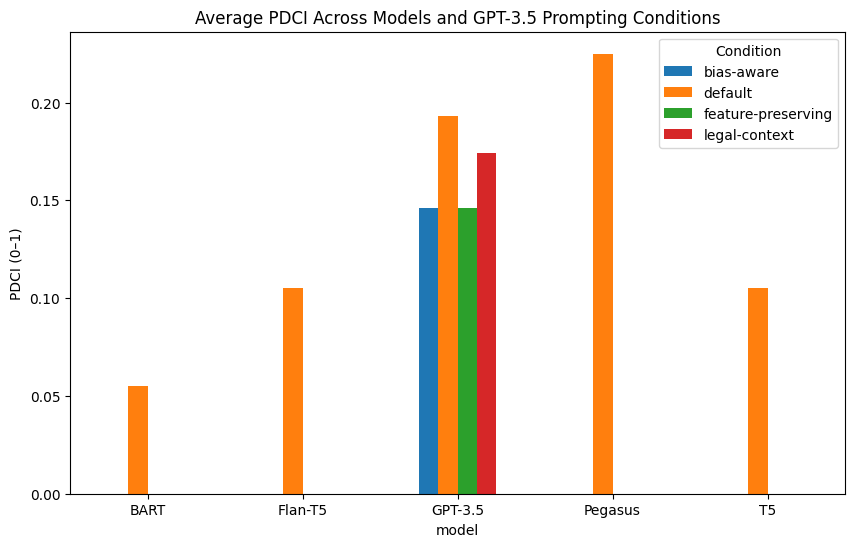

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_pegasus_out["model"] = "Pegasus"
df_bart_out["model"] = "BART"
df_t5_out["model"] = "T5"
df_flant5_out["model"] = "Flan-T5"
df_gpt_out["model"] = "GPT-3.5"   # already has "condition" column

# Combine everything
df_all = pd.concat([
    df_pegasus_out,
    df_bart_out,
    df_t5_out,
    df_flant5_out,
    df_gpt_out
], ignore_index=True)

# Aggregate mean scores
table = (
    df_all.groupby(["model","condition"])[["CII","PDS","PDCI"]]
    .mean()
    .round(3)
    .reset_index()
)

print("Average PDCI scores by model and condition")
display(table)

# Pivot for visualization (so we get bars per condition within each model)
pivot = table.pivot(index="model", columns="condition", values="PDCI")

# Plot
pivot.plot(kind="bar", figsize=(10,6))
plt.ylabel("PDCI (0–1)")
plt.title("Average PDCI Across Models and GPT-3.5 Prompting Conditions")
plt.xticks(rotation=0)
plt.legend(title="Condition")
plt.show()

Open-source models — mean PDCI


,model,PDCI
0,BART,0.055
1,Flan-T5,0.105
2,T5,0.105
3,Pegasus,0.225


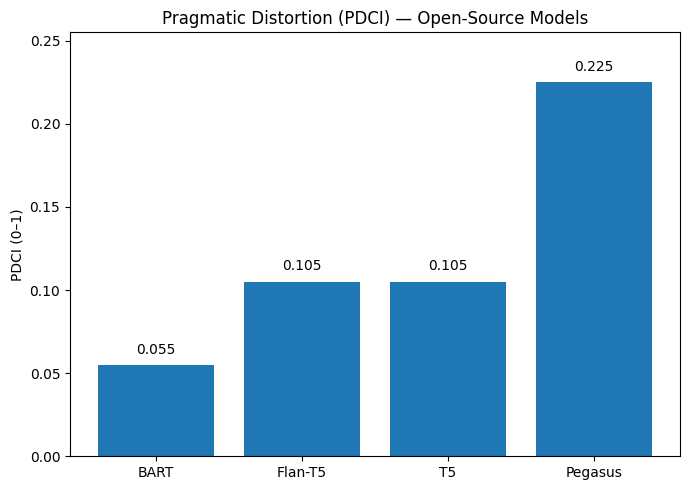

In [69]:
# --- Open-source models: PDCI only ---
os_models = ["BART", "T5", "Flan-T5", "Pegasus"]

os_table = (
    table[(table["model"].isin(os_models)) & (table["condition"] == "default")]
    .sort_values("PDCI")
    .reset_index(drop=True)
)

print("Open-source models — mean PDCI")
display(os_table[["model","PDCI"]])

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(os_table["model"], os_table["PDCI"])
for x, y in zip(os_table["model"], os_table["PDCI"]):
    plt.text(x, y + 0.005, f"{y:.3f}", ha="center", va="bottom", fontsize=10)
plt.ylim(0, max(0.01, os_table["PDCI"].max() + 0.03))
plt.ylabel("PDCI (0–1)")
plt.title("Pragmatic Distortion (PDCI) — Open-Source Models")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

GPT-3.5 — mean CII, PDS, PDCI by condition


,condition,CII,PDS,PDCI
2,bias-aware,0.078,0.214,0.146
3,default,0.134,0.252,0.193
4,feature-preserving,0.079,0.213,0.146
5,legal-context,0.117,0.232,0.174


<Figure size 900x500 with 0 Axes>

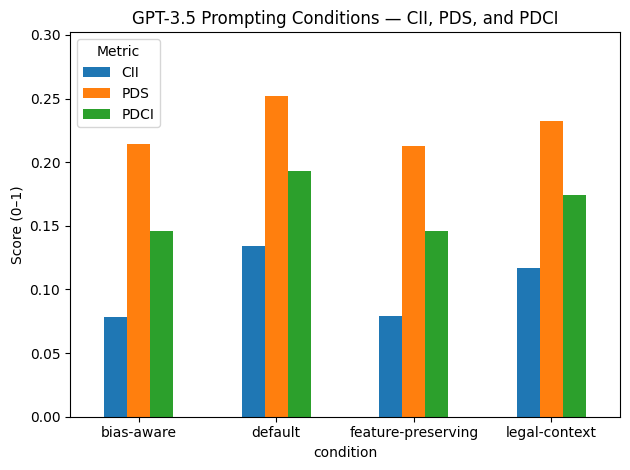

In [68]:
# --- GPT-3.5: show all three metrics by condition ---
gpt_table = table[table["model"] == "GPT-3.5"][["condition","CII","PDS","PDCI"]].copy()
print("GPT-3.5 — mean CII, PDS, PDCI by condition")
display(gpt_table)

pivot_gpt = gpt_table.set_index("condition")[["CII","PDS","PDCI"]]

plt.figure(figsize=(9,5))
pivot_gpt.plot(kind="bar")
plt.ylabel("Score (0–1)")
plt.title("GPT-3.5 Prompting Conditions — CII, PDS, and PDCI")
plt.xticks(rotation=0)
plt.ylim(0, min(1.0, pivot_gpt.values.max() + 0.05))
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


In [71]:
import pandas as pd

# --- Helper to ensure labels on each model frame ---
def label(df, model, condition="default"):
    df = df.copy()
    df["model"] = model
    if "condition" not in df.columns:
        df["condition"] = condition
    return df

# Label and combine (assumes you already have these *_out dataframes)
frames = [
    label(df_pegasus_out, "Pegasus"),
    label(df_bart_out,    "BART"),
    label(df_t5_out,      "T5"),
    label(df_flant5_out,   "Flan-T5"),
    label(df_gpt_out,     "GPT-3.5"),   # df_gpt_out already has 'condition'
]
df_all = pd.concat(frames, ignore_index=True)

# --- Mean score table ---
metrics = ["CII","PDS","PDCI"]
mean_table = (
    df_all.groupby(["model","condition"], as_index=False)[metrics]
    .mean()
    .round(3)
    .sort_values(["model","condition"])
)

# Display and save
display(mean_table)  # notebook table
print(mean_table.to_markdown(index=False))  # quick copy/paste for the dissertation
mean_table.to_csv("pdci_model_comparison_means.csv", index=False)

# (Optional) convenience tables
open_source_means = mean_table[mean_table["model"].isin(["BART","T5","Flan-T5","Pegasus"])]
gpt_means = mean_table[mean_table["model"]=="GPT-3.5"].sort_values("PDCI")
display(open_source_means)
display(gpt_means)


,model,condition,CII,PDS,PDCI
0,BART,default,0.032,0.078,0.055
1,Flan-T5,default,0.058,0.153,0.105
2,GPT-3.5,bias-aware,0.078,0.214,0.146
3,GPT-3.5,default,0.134,0.252,0.193
4,GPT-3.5,feature-preserving,0.079,0.213,0.146
5,GPT-3.5,legal-context,0.117,0.232,0.174
6,Pegasus,default,0.129,0.321,0.225
7,T5,default,0.058,0.153,0.105


| model   | condition          |   CII |   PDS |   PDCI |
|:--------|:-------------------|------:|------:|-------:|
| BART    | default            | 0.032 | 0.078 |  0.055 |
| Flan-T5 | default            | 0.058 | 0.153 |  0.105 |
| GPT-3.5 | bias-aware         | 0.078 | 0.214 |  0.146 |
| GPT-3.5 | default            | 0.134 | 0.252 |  0.193 |
| GPT-3.5 | feature-preserving | 0.079 | 0.213 |  0.146 |
| GPT-3.5 | legal-context      | 0.117 | 0.232 |  0.174 |
| Pegasus | default            | 0.129 | 0.321 |  0.225 |
| T5      | default            | 0.058 | 0.153 |  0.105 |


,model,condition,CII,PDS,PDCI
0,BART,default,0.032,0.078,0.055
1,Flan-T5,default,0.058,0.153,0.105
6,Pegasus,default,0.129,0.321,0.225
7,T5,default,0.058,0.153,0.105


,model,condition,CII,PDS,PDCI
2,GPT-3.5,bias-aware,0.078,0.214,0.146
4,GPT-3.5,feature-preserving,0.079,0.213,0.146
5,GPT-3.5,legal-context,0.117,0.232,0.174
3,GPT-3.5,default,0.134,0.252,0.193
